# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 05.10.2021

Мягкий дедлайн: 23:59MSK 19.10.2021

Жесткий дедлайн: 23:59MSK 23.10.2021

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{penalty} = M_{full} \cdot 0.85^{t/1440}$, где $M_{full}$ &mdash; полная оценка за работу без учета штрафа, а $t$ &mdash; время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше **8.5**, а если сдать перед самым жестким дедлайном, то ваш максимум &mdash; **5.22** балла.

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [2]:
import wget
import os
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip', 'data.txt.zip')
os.mkdir('data')
os.replace('data.txt.zip', 'data/data.txt.zip')
os.listdir('data')

In [3]:
df = pd.read_csv('data/data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
from sklearn.preprocessing import StandardScaler
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
scalerX = StandardScaler()
scalerY = StandardScaler()

X_train = scalerX.fit_transform(X[:train_size, :])
X_test = scalerX.transform(X[train_size:, :])

y_train = scalerY.fit_transform(y[:train_size].reshape(-1, 1))
y_test = scalerY.transform(y[train_size:].reshape(-1, 1))

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((463715, 90), (51630, 90), (463715, 1), (51630, 1))

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

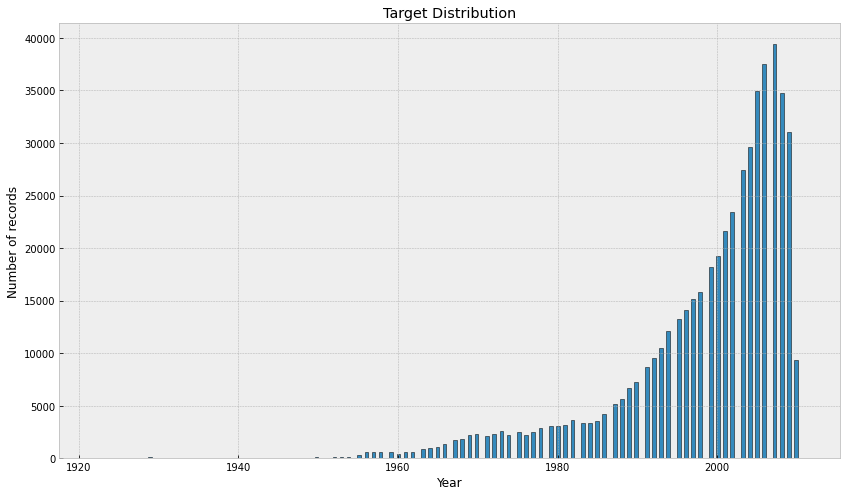

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 14, 8

plt.hist(df[0].values, bins=200, edgecolor = 'k')
plt.xlabel('Year')
plt.ylabel('Number of records')
plt.title('Target Distribution');
plt.show()

In [7]:
any(df.isna().sum() > 0), df.dtypes.unique()

(False, array([dtype('int64'), dtype('float64')], dtype=object))

Пропусков нет, все данные числовые. Классно.

Наилучшая константа для MSE - среднее. Посчитаем его на обучающей выборке и проверим качество на тестовой.

In [8]:
from sklearn.metrics import mean_squared_error
const = y_train.mean()
mean_squared_error(y_test, np.array([const for _ in range(len(y_test))]), squared=False) * scalerY.scale_[0]

10.852463905136338

Обучим `Ridge`.

In [9]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Train RMSLE = %.4f" % (mean_squared_error(y_train, y_train_pred, squared=False) * scalerY.scale_[0]))
print("Test RMSLE = %.4f" % (mean_squared_error(y_test, y_pred, squared=False) * scalerY.scale_[0]))

Train RMSLE = 9.5528
Test RMSLE = 9.5102


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знайте, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [10]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(10)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

X_train_tens = torch.from_numpy(X_train).float()
y_train_tens = torch.from_numpy(y_train).float().view(-1)
X_test_tens = torch.from_numpy(X_test).float()
y_test_tens = torch.from_numpy(y_test).float().view(-1)
X_valid_tens = torch.from_numpy(X_valid).float()
y_valid_tens = torch.from_numpy(y_valid).float().view(-1)

X_train_tens.shape, y_train_tens.shape, X_test_tens.shape, y_test_tens.shape, X_valid_tens.shape, y_valid_tens.shape

(torch.Size([370972, 90]),
 torch.Size([370972]),
 torch.Size([51630, 90]),
 torch.Size([51630]),
 torch.Size([92743, 90]),
 torch.Size([92743]))

In [12]:
BATCH_SZ = 300
DEVICE = 'cuda'

from torch.utils.data import Dataset, DataLoader
class Data_set(Dataset):
    def __init__(self, X, y=None):
        super().__init__()
        self.data = X
        self.answers = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.answers[index]
    
train_set = Data_set(X_train_tens, y_train_tens)
test_set = Data_set(X_test_tens, y_test_tens)
valid_set = Data_set(X_valid_tens, y_valid_tens)

train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SZ)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SZ)

In [13]:
class Model(nn.Module):
    def __init__(self, dims_list, DEVICE):
        super().__init__()

        self.Seq = nn.Sequential(
            nn.Linear(dims_list[0], dims_list[1]),
            nn.ReLU(),
            nn.Linear(dims_list[1], dims_list[2]),
            nn.Sigmoid(),
            nn.Linear(dims_list[2], dims_list[3]),
            nn.ReLU(),
            nn.Linear(dims_list[3], dims_list[4]) 
        ).to(DEVICE)

    def forward(self, x):
        x = self.Seq(x)
        return x
            
    
model = Model([90, 250, 400, 15, 1], DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-1, weight_decay=1e-4, lr_decay=0.001, eps=1e-12)

In [14]:
#%%writefile fitting.py
# w/ no scheduler
from IPython.display import display, clear_output

def train(model, optimizer, criterion, train_loader, valid_loader, test_loader, epochs=10, DEVICE='cpu'):
    
    metrics_dict = {
        "Epoch": [],
        "Train RMSE": [],
        "Valid RMSE": [],
        "Test RMSE": [],
    }
    for epoch in range(epochs):
        metrics_dict["Epoch"].append(epoch + 1)

        loss_at_train = 0 
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            y_pred = model(x_batch).view(-1)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            #scheduler.step()
            optimizer.zero_grad()
            with torch.no_grad():
                loss_at_train += (torch.square((y_pred - y_batch)).sum()).item()
        rmse_at_train = (loss_at_train / len(train_loader.dataset)) ** (1/2) * scalerY.scale_[0]
        metrics_dict["Train RMSE"].append(rmse_at_train)

        loss_at_valid = 0
        for batch_v in valid_loader:
            x_batch_v, y_batch_v = batch_v
            x_batch_v, y_batch_v = x_batch_v.to(DEVICE), y_batch_v.to(DEVICE)
            y_pred_v = model(x_batch_v).view(-1)
            with torch.no_grad():
                loss_at_valid += (torch.square((y_pred_v - y_batch_v)).sum()).item()
        rmse_at_valid = (loss_at_valid / len(valid_loader.dataset)) ** (1/2) * scalerY.scale_[0]
        metrics_dict["Valid RMSE"].append(rmse_at_valid)
        
        loss_at_test = 0
        for batch_t in test_loader:
            x_batch_t, y_batch_t = batch_t
            x_batch_t, y_batch_t = x_batch_t.to(DEVICE), y_batch_t.to(DEVICE)
            y_pred_t = model(x_batch_t).view(-1)
            with torch.no_grad():
                loss_at_test += (torch.square((y_pred_t - y_batch_t)).sum()).item()
        rmse_at_test = (loss_at_test / len(test_loader.dataset)) ** (1/2) * scalerY.scale_[0]
        metrics_dict["Test RMSE"].append(rmse_at_test)

        clear_output(wait=True)
        display(pd.DataFrame(metrics_dict))
        
    plt.plot(metrics_dict['Epoch'], metrics_dict['Train RMSE'], 'darkorchid', label='Train', linewidth=2)
    plt.plot(metrics_dict['Epoch'], metrics_dict['Valid RMSE'], 'crimson', label='Valid', linewidth=2)
    plt.plot(metrics_dict['Epoch'], metrics_dict['Test RMSE'], 'green', label='test', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(shadow=False, fontsize=14)
    plt.show()
    
def test(model, criterion, test_loader, test_set, DEVICE='cpu'):
    '''
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = torch.ones(len(test_loader.dataset))
    loss_at_test = 0
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(x_batch).view(-1)
        loss = criterion(y_pred, y_batch)
        with torch.no_grad():
            loss_at_test += (torch.square((y_pred - y_batch)).sum()).item()
    rmse_at_test = (loss_at_test / len(test_loader.dataset)) ** (1/2) * scalerY.scale_[0]
    print(rmse_at_test)
    
    return model(test_set.data.to(DEVICE))

,Epoch,Train RMSE,Valid RMSE,Test RMSE
0,1,10.314139,9.009055,9.028701
1,2,8.882465,8.829422,8.874629
2,3,8.757846,8.760430,8.837250
3,4,8.686820,8.717850,8.818328
4,5,8.636445,8.685033,8.789201
5,6,8.598368,8.683590,8.795010
6,7,8.569005,8.655459,8.774947
7,8,8.545896,8.646346,8.774263
8,9,8.527085,8.633969,8.762815
9,10,8.510153,8.626420,8.763919


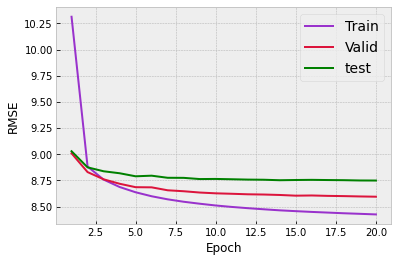

In [15]:
train(model, optimizer, criterion, train_loader, valid_loader, test_loader, epochs=20, DEVICE=DEVICE)

In [16]:
_ = test(model, criterion, test_loader, test_set, DEVICE=DEVICE)

8.748667813837498


In [17]:
assert test(model, criterion, test_loader, test_set, DEVICE=DEVICE).shape[0] == y_test.shape[0]

8.748667813837498


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Коротко и нежно
Основной моей целью было получение хорошего качества за малое число эпох (до 20). Было перепробовано очень много всего (и потрачено очень много времени): различные гиперпараметры, оптимизаторы, `BatchNorm` и `Dropout`, даже расписания. Попытался залезть в SWA, но быстро отбросил эту идею.
* Оптимизаторы. Лучше всех себя показали `Adagrad` и `Adadelta`. Пробовал `Adam`, `AdamW`, `SGD`. Последний (неизвестно почему) выдавал `NaN` на всех эпохах. В конечном итоге выбор пал на `Adagrad`, так как `Adadelta` показывал меньшую (но более плавную) сходимость.
* `scheduler`. Ничем не помогло. Абсолютно ничем.
* BatchNorm1d. Неизвестно, почему, но с нормой батча обучение хоть и шло, но ошибка на тесте была хуже, чем у `Ridge`-регрессии (порядка 9.6).
* Dropout. Пробовал ставить в разные места (после разных слоев). Видимого эффекта не дало, но при этом скорость сходимости очень (очень-очень) сильно падала.
* Гиперпараметры. Во-первых, лучше всего модели себя показывали с большим `lr` (от 8e-2 до 4e-1). Во-вторых, размер батча тоже сильно влиял как на качество обучения, так и на скорость обучения. Мои первые модели с `batchsize = 16` очень сильно переобучались с первых эпох (возможно, это проблема самих моделей). `batchsize = 64` показал себя хорошо, но свой выбор я оставил на 400. В-третьих, откзываться от регуляризации - дело плохое, поэтому был подобран `weight_decay = 1e-4`. Пробовал 1e-3, но данное значение показало себя хуже. `lr_decay` подбирался под `lr = 1e-1`. Подобранное значение показало себя лучше всего, при этом даже небольшее изменение (к примеру, с 0.001 до 0.0011) сильно влияло на модель не в лучшую сторону.
* Функции активации. `Sigmoid`, `ReLU`, `ReLU6` показали себя лучше всего. Кроме них я пробовал еще и `GELU`, `CELU`, `Tanh`, `LeakyReLU` в различных комбинациях. Мало чем помогло. В некоторых случаях неплохо работает `LogSigmoid`.
* Архитектура и конфигурация. Два варианта: на понижение размерности (пример: 90 - 70 - 40 - 1) и на повышение размерности (пример: 90 - 128 - 400 - 60 - 1). Как показала практика, если хорошо подобрать размерности, то и так и так хорошо.

### Модели (примеры) и комментарии
С Вашего позволения, я буду выводить график ошибки как на тестовой выборке, так и на валидационной.

### Модель 1: понижение размерности

,Epoch,Train RMSE,Valid RMSE,Test RMSE
0,1,8.939802,8.772282,8.897502
1,2,8.694675,8.695322,8.834773
2,3,8.618447,8.659223,8.829896
3,4,8.569795,8.666147,8.830908
4,5,8.526100,8.607738,8.811514
5,6,8.493307,8.586802,8.775879
6,7,8.461808,8.617978,8.807321
7,8,8.435222,8.618217,8.810240
8,9,8.410378,8.572132,8.815171
9,10,8.390800,8.582228,8.779453


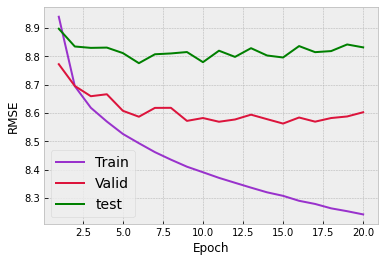

In [18]:
model_1 = nn.Sequential(
        nn.Linear(90, 80),
        nn.ReLU(),
        nn.Linear(80, 40),
        nn.Sigmoid(),
        nn.Linear(40, 20),
        nn.ReLU(),
        nn.Linear(20, 1) 
    ).to(DEVICE)

optimizer_1 = torch.optim.Adagrad(model_1.parameters(), lr=8e-2, weight_decay=1e-4)
train(model_1, optimizer_1, criterion, train_loader, valid_loader, test_loader, epochs=20, DEVICE=DEVICE)

Здесь мы получили 8.790485 на 10 эпохе. Дальше уже пошло переобучение. Но при этом на 6 эпохе было получено 8.783786, после чего был скачок вверх (видим на графике по тесту и валидации). После этого скачка качество на тесте просело (хоть и на валидации мы смогли спуститься немного пониже. По этой причине эта модель не кажется мне уж очень хорошей.

### Модель 2: что происходит с `BatchNorm`?
Возьмем ту же модель и добавим `BatchNorm1d`.

,Epoch,Train RMSE,Valid RMSE,Test RMSE
0,1,8.965160,8.786393,9.372648
1,2,8.725559,8.725698,9.340673
2,3,8.651828,8.667972,9.344293
3,4,8.605335,8.658232,9.324066
4,5,8.569433,8.667831,9.396212
5,6,8.539383,8.683024,9.418464
6,7,8.513945,8.646136,9.383358
7,8,8.498641,8.636160,9.379789


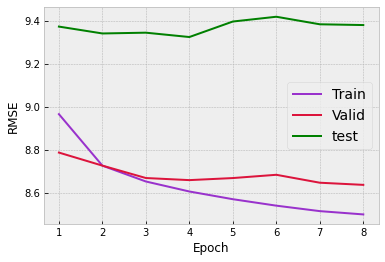

In [21]:
model_2 = nn.Sequential(
        nn.Linear(90, 80),
        nn.ReLU(),
        nn.Linear(80, 40),
        nn.BatchNorm1d(40),
        nn.Sigmoid(),
        nn.Linear(40, 20),
        nn.ReLU(),
        nn.Linear(20, 1) 
    ).to(DEVICE)

optimizer_2 = torch.optim.Adagrad(model_2.parameters(), lr=5e-2, weight_decay=1e-4)
train(model_2, optimizer_2, criterion, train_loader, valid_loader, test_loader, epochs=8, DEVICE=DEVICE)

Видим, что bn вообще никак не помогает. Я не знаю, с чем это связано, но вот так вот оно получается. Семинарист тоже не знает.
### Модель 3: повышение размерности

,Epoch,Train RMSE,Valid RMSE,Test RMSE
0,1,9.303690,9.020929,9.080916
1,2,8.905889,8.857083,8.966858
2,3,8.776467,8.785329,8.905555
3,4,8.695382,8.756146,8.915649
4,5,8.639069,8.696845,8.860399
5,6,8.593087,8.668586,8.843733
6,7,8.554464,8.652477,8.841938
7,8,8.521176,8.630569,8.861170
8,9,8.487544,8.639407,8.835341
9,10,8.457398,8.624565,8.844838


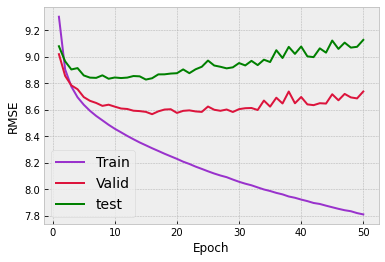

In [22]:
model_3 = nn.Sequential(
        nn.Linear(90, 128),
        nn.ReLU(),
        nn.Linear(128, 200),
        nn.ReLU(),
        nn.Linear(200, 1)
    ).to(DEVICE)

optimizer_3 = torch.optim.Adadelta(model_3.parameters(), lr=1e-1, weight_decay=1e-4)
train(model_3, optimizer_3, criterion, train_loader, valid_loader, test_loader, epochs=50, DEVICE=DEVICE)

По всей видимости, эта модель никогда не сойдется к хорошему качеству.

Главное проблема такой конфигурации - очень сложно ее угадать. Я попробовал мого подобных моделей на 3-4 слоя, и по опыту могу сказать, что часто происходит так, что сходимость получается рваной и долгой. Однако один раз удалось получить что-то годное, но это скорее чудо.
Попробуем другие похожие модели, но уже с усиленной регуляризацией:

,Epoch,Train RMSE,Valid RMSE,Test RMSE
0,1,10.655704,9.170544,9.534879
1,2,8.906503,8.863551,9.433416
2,3,8.818392,8.797393,9.425152
3,4,8.765090,8.799809,9.341616
4,5,8.734131,8.861892,9.399746
5,6,8.698709,8.793817,9.408454
6,7,8.677542,8.705754,9.320803
7,8,8.656369,8.759719,9.418001
8,9,8.641475,8.701186,9.358112
9,10,8.621615,8.663241,9.304262


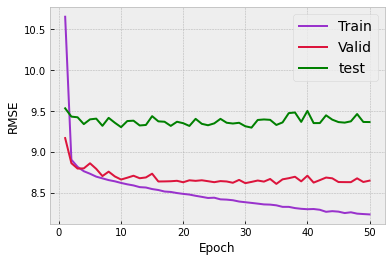

In [23]:
model_4 = nn.Sequential(
        nn.Linear(90, 512, bias=False),
        nn.ReLU(),
        nn.Dropout(0.3), 
        nn.BatchNorm1d(512),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.05),
        nn.Linear(1024, 256, bias=False),
        nn.Sigmoid(),
        nn.Linear(256, 1)
    ).to(DEVICE)

optimizer_4 = torch.optim.Adagrad(model_4.parameters(), lr=1e-1, weight_decay=1e-4)
train(model_4, optimizer_4, criterion, train_loader, valid_loader, test_loader, epochs=50, DEVICE=DEVICE)

,Epoch,Train RMSE,Valid RMSE,Test RMSE
0,1,9.575269,9.370160,9.691827
1,2,9.280960,9.226481,9.614281
2,3,9.228691,9.167316,9.562779
3,4,9.194043,9.178801,9.580069
4,5,9.181171,9.167336,9.606347
5,6,9.165961,9.141383,9.555447
6,7,9.157880,9.136503,9.544837
7,8,9.154017,9.130693,9.519900
8,9,9.141838,9.135093,9.526318
9,10,9.146595,9.126983,9.547943


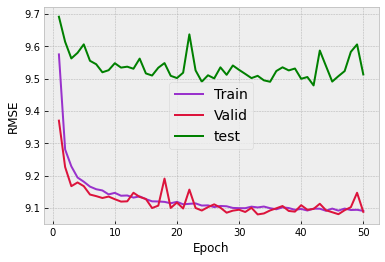

In [24]:
model_5 = nn.Sequential(
        nn.Linear(90, 400),
        nn.BatchNorm1d(400),
        nn.LogSigmoid(),
        nn.Dropout(0.2),
        nn.LeakyReLU(0.05),
        nn.Linear(400, 80),
        nn.ReLU6(0.05),
        nn.Linear(80, 1)
    ).to(DEVICE)

optimizer_5 = torch.optim.Adagrad(model_5.parameters(), lr=7e-2, weight_decay=1e-3)
train(model_5, optimizer_5, criterion, train_loader, valid_loader, test_loader, epochs=50, DEVICE=DEVICE)

## Вывод (по конкретной задаче)
* Если есть какая-то идея, то не нужно добивать ее до конца: лучше отметить недостатки и попробовать что-то другое;
* Лучше всего незначительно менять стандартные параметры в PyTorch и смотреть, как изменения этих параметрах влиет на поведение модели;
* Оптимизатор подбирается под архитектуру;
* Не знаю, насколько верно это утверждение, но я выявил, что *больше всего на сходимость влияет конфигурация графа вкупе с хорошо подобранным оптимизатором*;
* Полезно смотреть ошибку не только на валидации, но и на тесте (по началу я смотрел только по валидации);
* В данной задаче все же было бы неплохо использоваться SWA-модели. Имеется твердое ощущение, что обучающие данные и тестовая выборка отличаются по распределению. Гипотетически SWA могло бы помочь;
* Действительно неизвестно, почему норма батча работает (но не у меня);
* Стоит практически всегда стандартизировать данные.